$$\dfrac{P}{P_0}(z_0) = 1 + \dfrac{p_x^2 + p_y^2}{\lvert\mathbf{p}\rvert^2} \dfrac{3}{4} \int_0^{\infty} \operatorname{Re}\left\{\dfrac{s}{s_z} \left[r^s - s_z^2 r^p\right] e^{^2 i k_1 z_0 s_z} \right\}ds + \dfrac{p_z^2}{\lvert\mathbf{p}\rvert^2} \dfrac{3}{2} \int_0^{\infty} \operatorname{Re}\left\{\dfrac{s^3}{s_z} r^p e^{^2ik_1z_0s_z} \right\}ds $$

with:

$ s = k_\rho / k_1 \newline s_z = s_z(s) = \sqrt{1-s^2} = k_{z_1}/k_1 \newline k_{z_1} = \sqrt{k_1^2 - (k_x^2 + k_y^2)}  \newline k_{z_2} = \sqrt{k_2^2 - k_{\rho}^2}, \qquad\qquad\qquad\qquad\text{w.      }\quad k_{\rho}^2 = k_{x_2}^2 + k_{y_2}^2 $

Given the following geometry:
<div>
<img src="assets/geometry.png" width="500"/>
</div>

The dipole can be written as:

$ p_x = \lvert\mathbf{p}\rvert \sin(\theta) \cos(\phi) \newline $
$ p_y = \lvert\mathbf{p}\rvert \sin(\theta) \sin(\phi) \newline $
$ p_z = \lvert\mathbf{p}\rvert \cos(\theta) \newline $

so to simplify the main equation to:

$$\dfrac{P}{P_0}(z_0) = 1 + \sin^2(\theta) \dfrac{3}{4} \int_0^{\infty} \operatorname{Re}\left\{\dfrac{s}{s_z} \left[r^s - s_z^2 r^p\right] e^{2 i k_1 z_0 s_z} \right\}ds + \cos^2(\theta) \dfrac{3}{2} \int_0^{\infty} \operatorname{Re}\left\{\dfrac{s^3}{s_z} r^p e^{2ik_1z_0s_z} \right\}ds $$

For the integration we have:

$$\dfrac{P}{P_0}_{tot}(z_0) = 1 + f(\theta) \int_0^{1} I(s) ds + g(\theta) \int_0^{1} J(s) ds + f(\theta) \int_1^{\infty} I(s) ds + g(\theta) \int_1^{\infty} J(s) ds = \\[10pt] = \dfrac{P}{P_0}_{rad} + \dfrac{P}{P_0}_{non~rad}$$

![Alt text](assets/fresnel.png)

**Fresnel Coefficients**

$ r^s = \dfrac{k_{z_1} - k_{z_2}}{k_{z_1} + k_{z_2}} \\[10pt] r^p = \dfrac{\epsilon_2 k_{z_1} - \epsilon_1 k_{z_2}}{\epsilon_2 k_{z_1} + \epsilon_1 k_{z_2}} $

In [26]:
# imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse, linalg, integrate

In [88]:
e1 = 1
e2 = 2.25
wl = 488e-9  # m

theta = np.pi/2     # horizontal dipole

n1=np.sqrt(e1)
n2=np.sqrt(e2)

k1=n1*2*np.pi/wl    # k vector in layer 1 (air)
k2=n2*2*np.pi/wl    # k vector in layer 1 (aluminum)

z0n = np.linspace(0.001, 2, 1000)

In [89]:

def pp0_integrand(s, sz, rs, rp, z0, theta):
    return 1 + \
        np.sin(theta) * 3/4 * integrate.simpson(np.real(s/sz * (rs - sz**2 * rp) * np.exp(2*1j*k1*z0*sz)), s) + \
        np.cos(theta) * 3/2 * integrate.simpson(np.real(s**3/sz * rp * np.exp(2*1j*k1*z0*sz)), s)

def pp0_integrand_inf(s, e1, e2, k1, k2, z0, theta):
    sz = np.sqrt(1 - s**2 +0j)

    # k-vecs
    k1z = k1 * sz
    krho = k1 * s
    k2z = np.sqrt(k2**2 - krho**2 +0j)

    # Fresnel coeff.s
    rs = (k1z - k2z) / (k1z + k2z)
    rp = (e2 * k1z - e1 * k2z) / (e2 * k1z - e1 * k2z)

    return np.sin(theta)**2 * 3/4 * np.real(s/sz * (rs - sz**2 * rp) * np.exp(2*1j*k1*z0*sz)) + \
            np.cos(theta)**2 * 3/2 * np.real(s**3/sz * rp * np.exp(2*1j*k1*z0*sz))


gamma_rad = []
gamma_nonrad = []
for i, z0 in enumerate(z0n*wl):
    # first part of the integration: [0 ... 1]
    res_rad = integrate.quad(pp0_integrand_inf, 0, 1, args=(e1, e2, k1, k2, z0, theta))
    gamma_rad.append(1+res_rad[0])
    # second part of the integration: [1 ... ∞]
    res_nonrad = integrate.quad(pp0_integrand_inf, 1, np.inf, args=(e1, e2, k1, k2, z0, theta))
    gamma_nonrad.append(res_nonrad[0])

gamma_rad = np.array(gamma_rad)
gamma_nonrad = np.array(gamma_nonrad)
gamma_tot = gamma_rad + gamma_nonrad

C:\Users\amcar\AppData\Local\Temp\ipykernel_4588\2257397794.py:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_rad = integrate.quad(pp0_integrand_inf, 0, 1, args=(e1, e2, k1, k2, z0, theta))


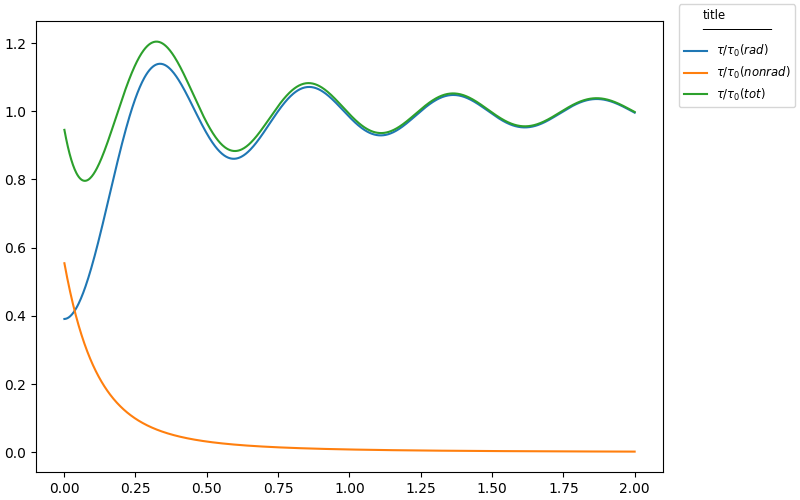

In [91]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(8,5), layout='constrained') # (width, height) in inches
ax.plot(z0n, gamma_rad, label=r"$\tau/\tau_0 (rad)$")
ax.plot(z0n, gamma_nonrad, label=r"$\tau/\tau_0 (non rad)$")
ax.plot(z0n, gamma_tot, label=r"$\tau/\tau_0 (tot)$")
l = ax.legend(bbox_to_anchor=[1.22, 1.05], loc='upper right', title="title\n──────────", fancybox=True, fontsize='small', title_fontsize='small')
# ax.set_xlim([0, 0.1])
# ax.set_ylim([0, 5])
plt.show()

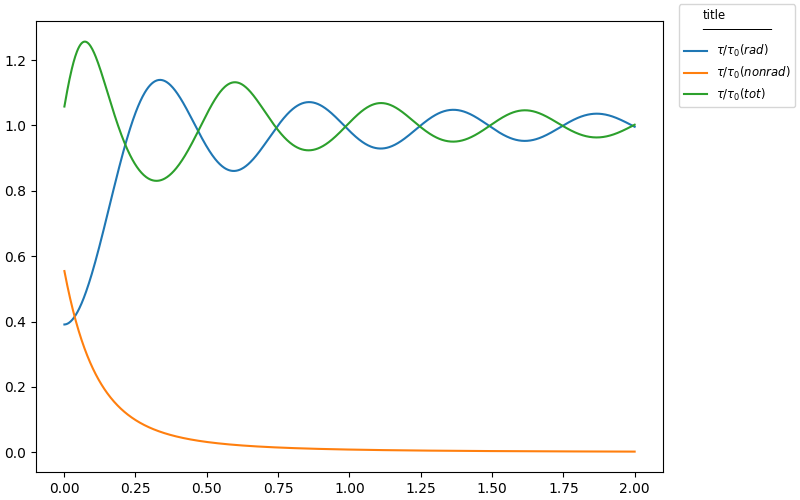

In [93]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(8,5), layout='constrained') # (width, height) in inches
ax.plot(z0n, gamma_rad, label=r"$\tau/\tau_0 (rad)$")
ax.plot(z0n, gamma_nonrad, label=r"$\tau/\tau_0 (non rad)$")
ax.plot(z0n, 1/gamma_tot, label=r"$\tau/\tau_0 (tot)$")
l = ax.legend(bbox_to_anchor=[1.22, 1.05], loc='upper right', title="title\n──────────", fancybox=True, fontsize='small', title_fontsize='small')
# ax.set_xlim([0, 0.1])
# ax.set_ylim([0, 5])
plt.show()